# **Escuela Politecnica Nacional**

# **[Taller 04] splines cúbicos**

## **Nombres:** Sebastián Morales, Moisés Pineda

**Link al repositorio:** https://github.com/SantiagoTmg/Metodos_Numericos_GRCC1/tree/main/Talleres/Taller4

In [33]:
import sympy as sym
from IPython.display import display


# ###################################################################
def cubic_spline(xs: list[float], ys: list[float]) -> list[sym.Symbol]:
    """
    Cubic spline interpolation ``S``. Every two points are interpolated by a cubic polynomial
    ``S_j`` of the form ``S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3.``

    xs must be different  but not necessarily ordered nor equally spaced.

    ## Parameters
    - xs, ys: points to be interpolated

    ## Return
    - List of symbolic expressions for the cubic spline interpolation.
    """

    points = sorted(zip(xs, ys), key=lambda x: x[0])  # sort points by x

    xs = [x for x, _ in points]
    ys = [y for _, y in points]

    n = len(points) - 1  # number of splines

    h = [xs[i + 1] - xs[i] for i in range(n)]  # distances between  contiguous xs

    alpha = [0] * n
    for i in range(1, n):
        alpha[i] = 3 / h[i] * (ys[i + 1] - ys[i]) - 3 / h[i - 1] * (ys[i] - ys[i - 1])

    l = [1]
    u = [0]
    z = [0]

    for i in range(1, n):
        l += [2 * (xs[i + 1] - xs[i - 1]) - h[i - 1] * u[i - 1]]
        u += [h[i] / l[i]]
        z.append((alpha[i] - h[i-1] * z[i-1] )/ l[i])


    l.append(1)
    z.append(0)
    c = [0] * (n + 1)

    x = sym.Symbol("x")
    splines = []
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b = (ys[j + 1] - ys[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d = (c[j + 1] - c[j]) / (3 * h[j])
        a = ys[j]
        print(j, a, b, c[j], d)
        S  = a + b * (x-xs[j]) + c[j] * (x-xs[j])**2 + d * (x-xs[j])**3

        splines.append(S)
    splines.reverse()
    return splines

In [34]:
import sympy as sym
from IPython.display import display


# ###################################################################
def cubic_spline_clamped(
    xs: list[float], ys: list[float], B0: float, B1: float
) -> list[sym.Symbol]:
    """
    Cubic spline interpolation ``S``. Every two points are interpolated by a cubic polynomial
    ``S_j`` of the form ``S_j(x) = a_j + b_j(x - x_j) + c_j(x - x_j)^2 + d_j(x - x_j)^3.``

    xs must be different  but not necessarily ordered nor equally spaced.

    ## Parameters
    - xs, ys: points to be interpolated
    - B0, B1: derivatives at the first and last points

    ## Return
    - List of symbolic expressions for the cubic spline interpolation.
    """

    points = sorted(zip(xs, ys), key=lambda x: x[0])  # sort points by x
    xs = [x for x, _ in points]
    ys = [y for _, y in points]
    n = len(points) - 1  # number of splines
    h = [xs[i + 1] - xs[i] for i in range(n)]  # distances between  contiguous xs

    alpha = [0] * (n + 1)  # prealloc
    alpha[0] = 3 / h[0] * (ys[1] - ys[0]) - 3 * B0
    alpha[-1] = 3 * B1 - 3 / h[n - 1] * (ys[n] - ys[n - 1])

    for i in range(1, n):
        alpha[i] = 3 / h[i] * (ys[i + 1] - ys[i]) - 3 / h[i - 1] * (ys[i] - ys[i - 1])

    l = [2 * h[0]]
    u = [0.5]
    z = [alpha[0] / l[0]]

    for i in range(1, n):
        l += [2 * (xs[i + 1] - xs[i - 1]) - h[i - 1] * u[i - 1]]
        u += [h[i] / l[i]]
        z += [(alpha[i] - h[i - 1] * z[i - 1]) / l[i]]

    l.append(h[n - 1] * (2 - u[n - 1]))
    z.append((alpha[n] - h[n - 1] * z[n - 1]) / l[n])
    c = [0] * (n + 1)  # prealloc
    c[-1] = z[-1]

    x = sym.Symbol("x")
    splines = []
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - u[j] * c[j + 1]
        b = (ys[j + 1] - ys[j]) / h[j] - h[j] * (c[j + 1] + 2 * c[j]) / 3
        d = (c[j + 1] - c[j]) / (3 * h[j])
        a = ys[j]
        print(j, a, b, c[j], d)
        S = a + b * (x - xs[j]) + c[j] * (x - xs[j]) ** 2 + d * (x - xs[j]) ** 3

        splines.append(S)
    splines.reverse()
    return splines

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify
import sympy as sym

def plot_splines(splines, intervals, points, title="Interpolación por Splines Cúbicos"):
    """
    Plot cubic splines and interpolation points
    """
    plt.figure(figsize=(10, 6))


    xs = [x for x, _ in points]
    ys = [y for _, y in points]


    plt.scatter(xs, ys, color='red', s=100, zorder=3, label='Puntos de interpolación')


    x_sym = sym.Symbol('x')
    for j, (S, (x_start, x_end)) in enumerate(zip(splines, zip(intervals[:-1], intervals[1:]))):
        x_range = np.linspace(x_start, x_end, 100)
        S_func = lambdify(x_sym, S, 'numpy')
        y_vals = S_func(x_range)
        plt.plot(x_range, y_vals, label=f'S_{j}(x)')

    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('S(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

**Compruebe gráficamente la solución de los siguientes ejercicios:**

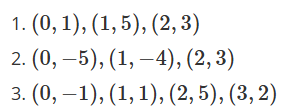

#### 1.

In [36]:
xs = [0, 1, 2]
ys = [1, 5, 3]

splines = cubic_spline(xs=xs, ys=ys)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1 5 1.0 -4.5 1.5
0 1 5.5 0.0 -1.5


-1.5*x**3 + 5.5*x + 1

1.0*x + 1.5*(x - 1)**3 - 4.5*(x - 1)**2 + 4.0

______


-1.5*x**3 + 5.5*x + 1

1.5*x**3 - 9.0*x**2 + 14.5*x - 2.0

1 5 1.0 -4.5 1.5
0 1 5.5 0.0 -1.5


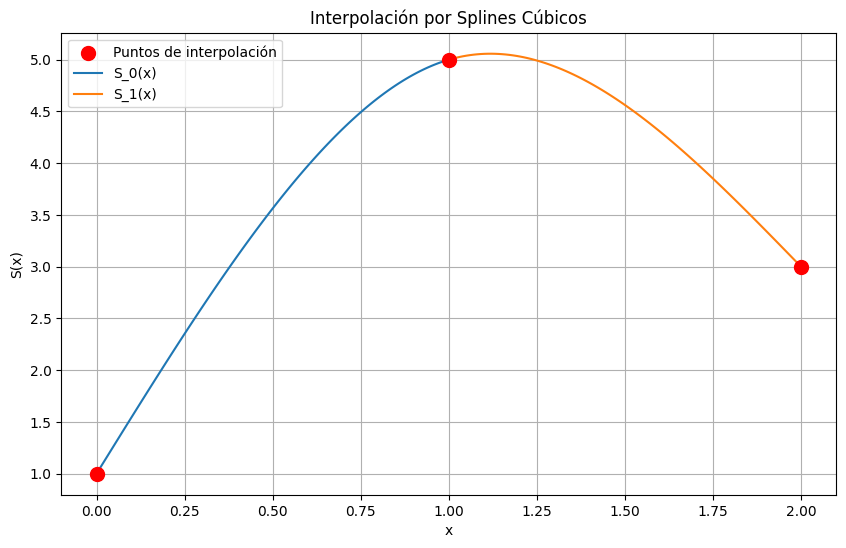


Ecuaciones de los splines:
S_0(x) = -1.5*x**3 + 5.5*x + 1
S_1(x) = 1.5*x**3 - 9.0*x**2 + 14.5*x - 2.0


In [37]:
sorted_points = sorted(zip(xs, ys), key=lambda x: x[0])
sorted_xs = [x for x, _ in sorted_points]
sorted_ys = [y for _, y in sorted_points]

splines = cubic_spline(xs=sorted_xs, ys=sorted_ys)

intervals = sorted_xs
points = sorted_points

plot_splines(splines, intervals, points)

print("\nEcuaciones de los splines:")
for i, s in enumerate(splines):
    print(f"S_{i}(x) = {s.simplify()}")

#### 2.

In [38]:
xs_1 = [0, 1, 2]
ys_1 = [-5, -4, 3]

splines_1 = cubic_spline(xs=xs_1, ys=ys_1)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1 -4 4.0 4.5 -1.5
0 -5 -0.5 0.0 1.5


-1.5*x**3 + 5.5*x + 1

1.0*x + 1.5*(x - 1)**3 - 4.5*(x - 1)**2 + 4.0

______


-1.5*x**3 + 5.5*x + 1

1.5*x**3 - 9.0*x**2 + 14.5*x - 2.0

1 -4 4.0 4.5 -1.5
0 -5 -0.5 0.0 1.5


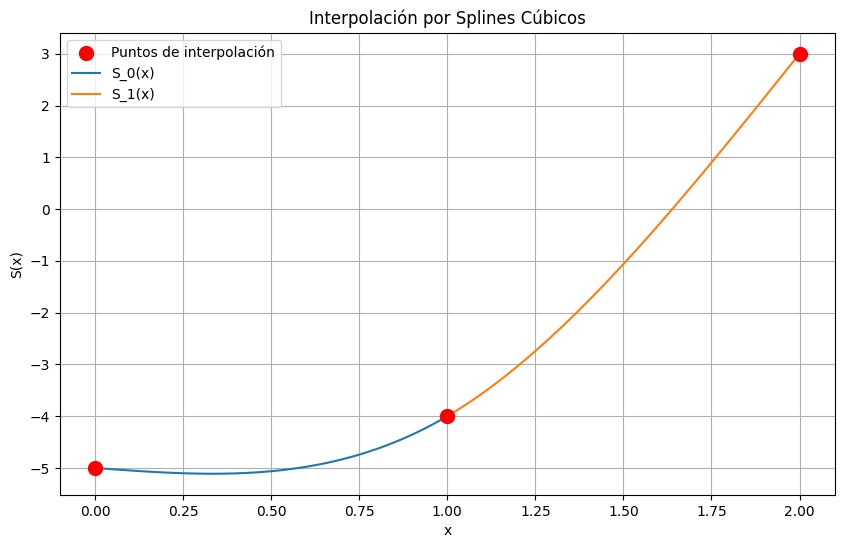


Ecuaciones de los splines:
S_0(x) = 1.5*x**3 - 0.5*x - 5
S_1(x) = -1.5*x**3 + 9.0*x**2 - 9.5*x - 2.0


In [39]:
sorted_points = sorted(zip(xs_1, ys_1), key=lambda x: x[0])
sorted_xs = [x for x, _ in sorted_points]
sorted_ys = [y for _, y in sorted_points]


splines = cubic_spline(xs=sorted_xs, ys=sorted_ys)

intervals = sorted_xs
points = sorted_points

plot_splines(splines, intervals, points)

print("\nEcuaciones de los splines:")
for i, s in enumerate(splines):
    print(f"S_{i}(x) = {s.simplify()}")

#### 3.

In [40]:
xs_2 = [0, 1, 2, 3]
ys_2 = [-1, 1, 5, 2]

splines_2 = cubic_spline(xs=xs_2, ys=ys_2)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

2 5 1.0 -6.0 2.0
1 1 4.0 3.0 -3.0
0 -1 1.0 0.0 1.0


1.5*x**3 - 0.5*x - 5

4.0*x - 1.5*(x - 1)**3 + 4.5*(x - 1)**2 - 8.0

______


1.5*x**3 - 0.5*x - 5

-1.5*x**3 + 9.0*x**2 - 9.5*x - 2.0

2 5 1.0 -6.0 2.0
1 1 4.0 3.0 -3.0
0 -1 1.0 0.0 1.0


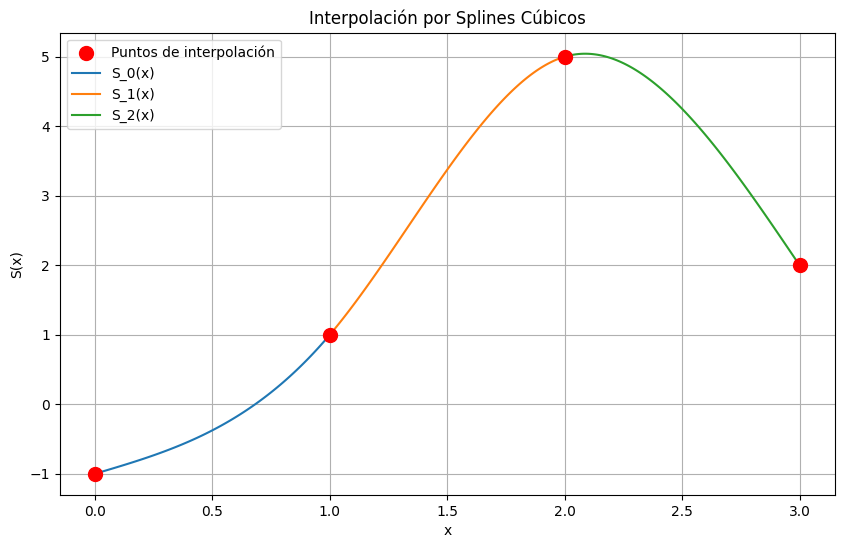


Ecuaciones de los splines:
S_0(x) = 1.0*x**3 + 1.0*x - 1.0
S_1(x) = -3.0*x**3 + 12.0*x**2 - 11.0*x + 3.0
S_2(x) = 2.0*x**3 - 18.0*x**2 + 49.0*x - 37.0


In [41]:
sorted_points = sorted(zip(xs_2, ys_2), key=lambda x: x[0])
sorted_xs = [x for x, _ in sorted_points]
sorted_ys = [y for _, y in sorted_points]

# Added B0 and B1 arguments with example values
splines = cubic_spline(xs=sorted_xs, ys=sorted_ys)

intervals = sorted_xs
points = sorted_points

plot_splines(splines, intervals, points)

print("\nEcuaciones de los splines:")
for i, s in enumerate(splines):
    print(f"S_{i}(x) = {s.simplify()}")

**Para cada uno de los ejercicios anteriores, resuelva los splines cúbicos de frontera condicionada con B0=1 para todos los valores de B1∈R.**

**Realice una animación de la variación de los splines cúbicos al variar  B1**

**Ejercicio 1**

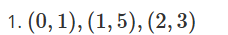

1 5 -1.25 -13.5 12.75
0 1 1.0 11.25 -8.25


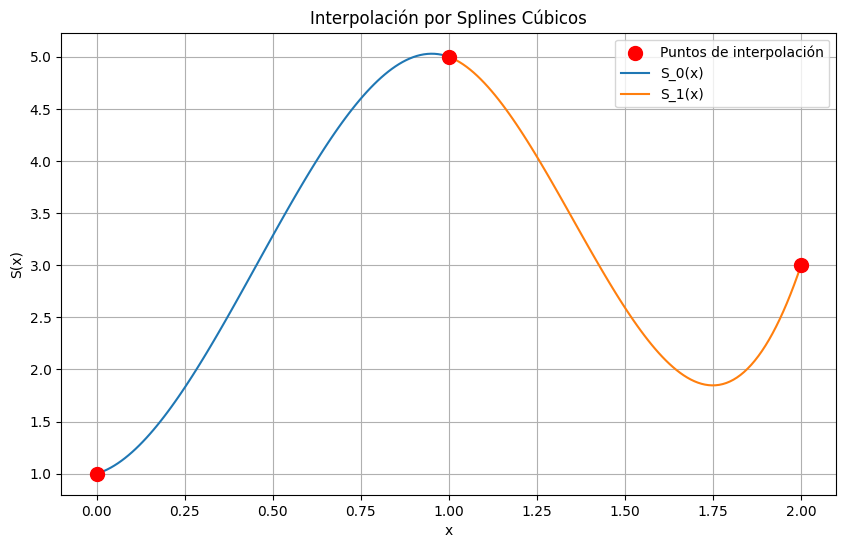


Ecuaciones de los splines:
S_0(x) = -8.25*x**3 + 11.25*x**2 + 1.0*x + 1
S_1(x) = 12.75*x**3 - 51.75*x**2 + 64.0*x - 20.0


In [42]:
xs = [0, 1, 2]
ys = [1, 5, 3]

sorted_points = sorted(zip(xs, ys), key=lambda x: x[0])
sorted_xs = [x for x, _ in sorted_points]
sorted_ys = [y for _, y in sorted_points]

# Added B0 and B1 arguments with example values
splines = cubic_spline_clamped(xs=sorted_xs, ys=sorted_ys, B0=1, B1=10)

intervals = sorted_xs
points = sorted_points

plot_splines(splines, intervals, points)

print("\nEcuaciones de los splines:")
for i, s in enumerate(splines):
    print(f"S_{i}(x) = {s.simplify()}")

**Ejercicio 2**

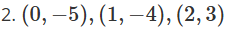

In [43]:
xs_1 = [0, 1, 2]
ys_1 = [-5, -4, 3]

splines_1 = cubic_spline(xs=xs_1, ys=ys_1)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

1 -4 4.0 4.5 -1.5
0 -5 -0.5 0.0 1.5


-8.25*x**3 + 11.25*x**2 + 1.0*x + 1

-1.25*x + 12.75*(x - 1)**3 - 13.5*(x - 1)**2 + 6.25

______


-8.25*x**3 + 11.25*x**2 + 1.0*x + 1

12.75*x**3 - 51.75*x**2 + 64.0*x - 20.0

1 -4 3.2499999999999996 4.500000000000001 -0.7500000000000004
0 -5 1.0 -2.2500000000000004 2.2500000000000004


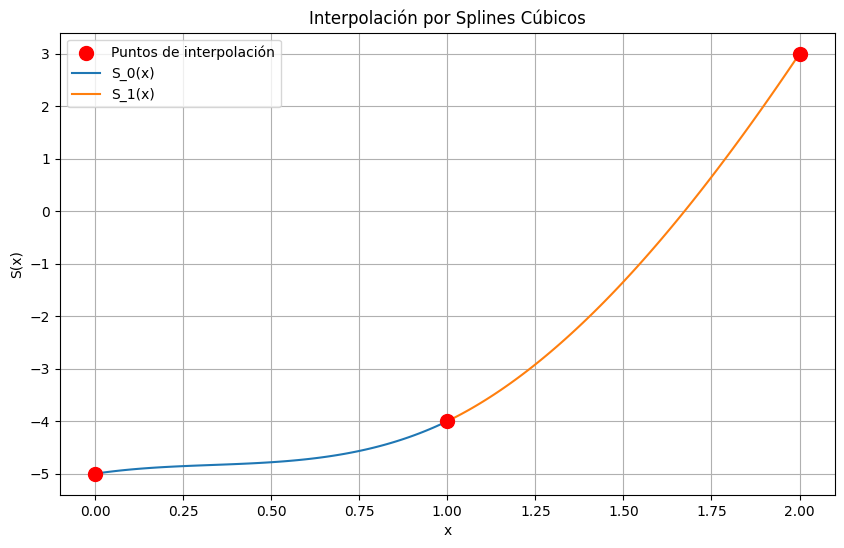


Ecuaciones de los splines:
S_0(x) = 2.25*x**3 - 2.25*x**2 + 1.0*x - 5
S_1(x) = -0.75*x**3 + 6.75*x**2 - 8.0*x - 2.0


In [44]:
sorted_points = sorted(zip(xs_1, ys_1), key=lambda x: x[0])
sorted_xs = [x for x, _ in sorted_points]
sorted_ys = [y for _, y in sorted_points]

splines = cubic_spline_clamped(xs=sorted_xs, ys=sorted_ys, B0=1, B1=10)

intervals = sorted_xs
points = sorted_points

plot_splines(splines, intervals, points)

print("\nEcuaciones de los splines:")
for i, s in enumerate(splines):
    print(f"S_{i}(x) = {s.simplify()}")

**Ejercicio 3:**

In [45]:
xs_2 = [0, 1, 2, 3]
ys_2 = [-1, 1, 5, 2]

splines_2 = cubic_spline(xs=xs_2, ys=ys_2)
_ = [display(s) for s in splines]
print("______")
_ = [display(s.expand()) for s in splines]

2 5 1.0 -6.0 2.0
1 1 4.0 3.0 -3.0
0 -1 1.0 0.0 1.0


2.25*x**3 - 2.25*x**2 + 1.0*x - 5

3.25*x - 0.75*(x - 1)**3 + 4.5*(x - 1)**2 - 7.25

______


2.25*x**3 - 2.25*x**2 + 1.0*x - 5

-0.75*x**3 + 6.75*x**2 - 8.0*x - 2.0

2 5 -3.0 -13.0 13.0
1 1 5.0 5.0 -6.0
0 -1 1.0 -1.0 2.0


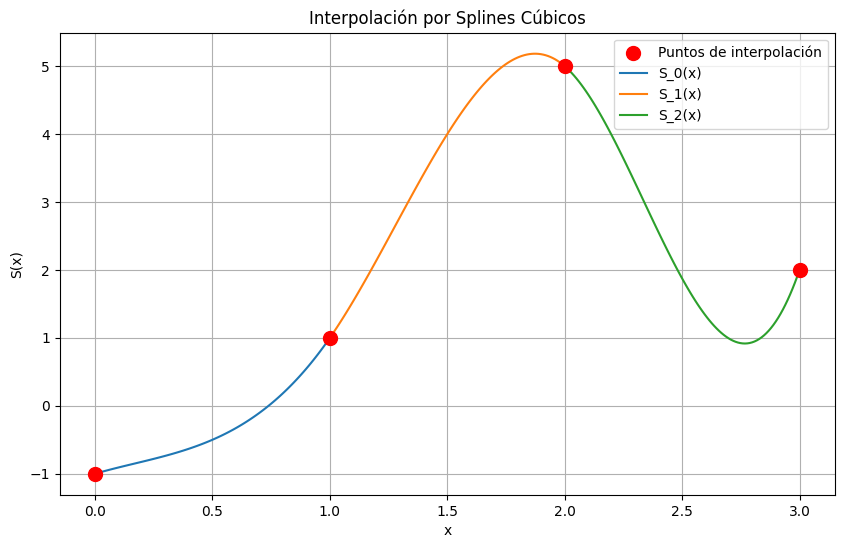


Ecuaciones de los splines:
S_0(x) = 2.0*x**3 - 1.0*x**2 + 1.0*x - 1
S_1(x) = -6.0*x**3 + 23.0*x**2 - 23.0*x + 7.0
S_2(x) = 13.0*x**3 - 91.0*x**2 + 205.0*x - 145.0


In [46]:
sorted_points = sorted(zip(xs_2, ys_2), key=lambda x: x[0])
sorted_xs = [x for x, _ in sorted_points]
sorted_ys = [y for _, y in sorted_points]

splines = cubic_spline_clamped(xs=sorted_xs, ys=sorted_ys, B0=1, B1=10)

intervals = sorted_xs
points = sorted_points

plot_splines(splines, intervals, points)

print("\nEcuaciones de los splines:")
for i, s in enumerate(splines):
    print(f"S_{i}(x) = {s.simplify()}")

**Realice una animación de la variación de los splines cúbicos al variar B1:**

La animación se encuentra en el archivo animacion.py en el repositorio

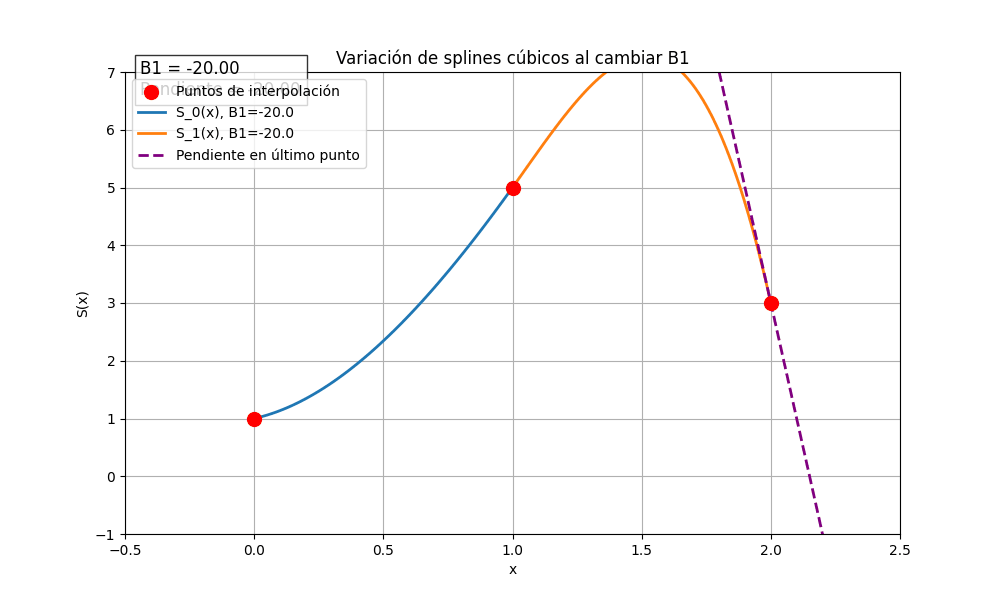